Replicate results in ICWSM 2018 paper.

In [50]:
%load_ext autoreload
%autoreload 2

from collections import Counter, defaultdict
from itertools import chain, combinations, cycle
from IPython.display import display
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import tarfile
from urllib.request import urlretrieve
path = 'data/'
os.environ['NOBULL_PATH'] = path
import u
%matplotlib inline
u.config_matplotlib()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
def download_data(path):
    """
    Download any required files if not already present.
    """
    url = 'https://www.dropbox.com/s/hkf52ggtl07bjh1/data.tgz?dl=1'
    if not os.path.exists(path + os.path.sep + 'model.w2v'):
        zipname = 'data.tgz'
        print('fetching data (1.5G)')
        urlretrieve(url, zipname)
        tar = tarfile.open(zipname, "r:gz")
        print('extracting %s' % zipname)
        tar.extractall()
        tar.close()
    else:
        print('data already exists in %s' % path)

download_data(path)

data already exists in data/


## Task 1

Given first $N$ comments, predict whether a hostile comment will appear $K$ hours in the future or later.

In [69]:
task1_posts = u.load_posts(path + 'task1_data.json', path + 'task1_labels.json')
print('read %d posts' % len(task1_posts))

read 1134 posts


In [70]:
def get_feature_indices(feature_names, feature_classes):
    print('%d feature classes, %d features' % (len(feature_classes), sum(len(f) for f in feature_names)))
    res = {}
    i = 0
    for fc, fns in zip(feature_classes, feature_names):
        res[fc] = np.arange(i, i+len(fns))
        i += len(fns)
    return res
    
def concat_indices(feature_class2indices, classes):
    return np.concatenate([feature_class2indices[c] for c in classes])
    
def enum_feature_subsets(feature_class2indices):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(feature_class2indices.keys())
    return ((classes, concat_indices(feature_class2indices, classes))
             for classes in chain.from_iterable(combinations(s, r)
                                                for r in range(1, len(s)+1)))

def select_results(results, num_features, used_features):
    selected = []
    for i, r in enumerate(results.iterrows()):
        if len(r[1]['features']) == num_features and len(used_features - set(r[1]['features'])) == 0:
            selected.append(i)
    return results.iloc[selected]

def print_results_table(results):
    """
    Print feature comparison table.
    """
    res = select_results(results, 2, set(['Unigram']))
    table = pd.concat([results[results.features==('Unigram',)],
                       res.sort_values('AUC', ascending=True),
                       results.sort_values('AUC', ascending=False).head(1)])
    print('best features:', table.features.values[-1])
    pd.options.display.max_colwidth = 100
    names = [t[0] if len(t) == 1 else 'U + %s' % t[1] for t in table['features']]
    names[-1] = 'Best'
    table['features'] = names
    table = table[['features', 'AUC', 'F1', 'Precision', 'Recall']]
    table = table.set_index('features')
    display(table.iloc[0])
    display(table)
    print(table.to_latex(bold_rows=True, float_format='%.3f', index=True))
    
def get_lines():
    random.seed(42)
    markers = ['o', '^', 's', '*', 'D']
    lines = ['-', '--', '-.', ':', '--']
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    for i in range(5):
        mi = list(markers)
        random.shuffle(mi)
        markers += mi
        li = list(lines)
        random.shuffle(li)
        lines += li
        ci = list(colors)
        random.shuffle(ci)
        colors += ci
    return cycle(['%s%s%s' % (c, m, l) for c, l, m in zip(colors, lines, markers)])

In [81]:
def task1_expts(posts, lead_time=3, max_lead_time=10):
    #task1_sampled_posts = u.sample_posts_task1(posts, lead_time=lead_time*60*60)
    # use same max lead time in figure below to ensure same posts are used.
    task1_sampled_posts = u.sample_posts_task1(posts, lead_time=max_lead_time*60*60)
    task1_sampled_posts = u.set_observed_comments(task1_sampled_posts, lead_time=lead_time*60*60)
    X, vec, feature_names, feature_classes = u.vectorize(task1_sampled_posts)
    feature_class2indices = get_feature_indices(feature_names, feature_classes)
    display(sorted([(fc, len(i)) for fc, i in feature_class2indices.items()], key=lambda x: x[1]))
    all_results = []
    y = np.array([1 if p['num_hostile'] > 0 else 0 for p in task1_sampled_posts])
    label_counts = Counter(y)
    print(label_counts)
    for feature_classes, col_indices in enum_feature_subsets(feature_class2indices):                        
        res = {
                'features': feature_classes,
                'n_instances': len(y),
                'n_pos': label_counts[1],
                'n_neg': label_counts[0]}
        XX = X[:,col_indices]
        # run cross-validation
        n_comments = np.array([p['n_comments_observed'] for p in task1_sampled_posts])
        res.update(u.cv(XX, y, n_splits=10, n_comments=n_comments))
        all_results.append(res)
    return pd.DataFrame(all_results), feature_class2indices
            
task1_results, feature_class2indices = task1_expts(task1_posts, lead_time=3)
print_results_table(task1_results)

total non-zero posts 234
sampled 234 negative posts
sampled 234 positive posts
9 feature classes, 11799 features


[('user', 2),
 ('trend', 4),
 ('lex', 16),
 ('n-w2v', 200),
 ('w2v', 200),
 ('final-com', 645),
 ('Unigram', 2611),
 ('prev-post', 2879),
 ('prev-com', 5242)]

Counter({1: 234, 0: 234})
best features: ('Unigram', 'lex', 'n-w2v', 'prev-post', 'trend', 'user', 'final-com')


AUC          0.790130
F1           0.736968
Precision    0.723493
Recall       0.778132
Name: Unigram, dtype: float64

,AUC,F1,Precision,Recall
features,,,,
Unigram,0.790130,0.736968,0.723493,0.778132
U + prev-com,0.707189,0.672451,0.659980,0.692705
U + final-com,0.779226,0.728765,0.716106,0.756771
U + trend,0.790178,0.738603,0.724736,0.776317
U + user,0.791465,0.741636,0.728868,0.778132
U + lex,0.792291,0.750477,0.731800,0.788126
U + w2v,0.793798,0.725019,0.715203,0.748552
U + n-w2v,0.809931,0.735855,0.725346,0.746161
U + prev-post,0.828154,0.761089,0.755658,0.764819


\begin{tabular}{lrrrr}
\toprule
{} &   AUC &    F1 &  Precision &  Recall \\
\textbf{features     } &       &       &            &         \\
\midrule
\textbf{Unigram      } & 0.790 & 0.737 &      0.723 &   0.778 \\
\textbf{U + prev-com } & 0.707 & 0.672 &      0.660 &   0.693 \\
\textbf{U + final-com} & 0.779 & 0.729 &      0.716 &   0.757 \\
\textbf{U + trend    } & 0.790 & 0.739 &      0.725 &   0.776 \\
\textbf{U + user     } & 0.791 & 0.742 &      0.729 &   0.778 \\
\textbf{U + lex      } & 0.792 & 0.750 &      0.732 &   0.788 \\
\textbf{U + w2v      } & 0.794 & 0.725 &      0.715 &   0.749 \\
\textbf{U + n-w2v    } & 0.810 & 0.736 &      0.725 &   0.746 \\
\textbf{U + prev-post} & 0.828 & 0.761 &      0.756 &   0.765 \\
\textbf{Best         } & 0.843 & 0.765 &      0.755 &   0.778 \\
\bottomrule
\end{tabular}



total non-zero posts 234
sampled 234 negative posts
sampled 234 positive posts
9 feature classes, 11884 features
9 feature classes, 11799 features
9 feature classes, 11740 features
9 feature classes, 11646 features
9 feature classes, 11606 features


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


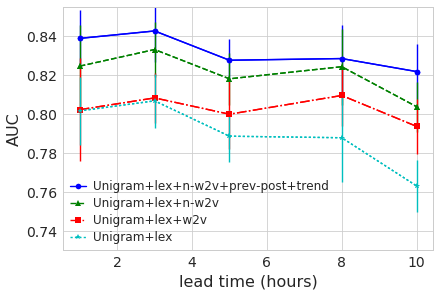

In [82]:
# Create table of AUC vs lead time
def task1_lead_time_fig(posts, lead_times, features):
    # resample and vectorize according to each lead_time
    all_results = []
    # to ensure comparability, we'll sample posts using longest lead times, then
    # reuse the for shorter lead times
    posts = u.sample_posts_task1(posts, lead_time=max(lead_times)*60*60)
    for lead_time in lead_times:
        task1_sampled_posts = u.set_observed_comments(posts, lead_time=lead_time*60*60)
        X, vec, feature_names, feature_classes = u.vectorize(task1_sampled_posts)
        feature_class2indices = get_feature_indices(feature_names, feature_classes)
        y = np.array([1 if p['num_hostile'] > 0 else 0 for p in task1_sampled_posts])        
        label_counts = Counter(y)
        n_comments = np.array([p['n_comments_observed'] for p in task1_sampled_posts])
        for feature_list in features:
            col_indices = concat_indices(feature_class2indices, feature_list)
            XX = X[:, col_indices]
            res = {
                    'features': feature_list,
                    'lead_time': lead_time,
                    'n_instances': len(y),
                    'n_pos': label_counts[1],
                    'n_neg': label_counts[0]}            
            # run cross-validation
            res.update(u.cv(XX, y, n_splits=10, n_comments=n_comments))
            all_results.append(res)
    results_df = pd.DataFrame(all_results)
    plot_task1_lead_time_fig(results_df)
    return results_df
            
def plot_task1_lead_time_fig(task1_res_fig, nfolds=10):
    plt.figure()
    linecycler = get_lines()
    for fnames in sorted([x for x in set(task1_res_fig.features)], key=lambda x: -len(x)):
        df = task1_res_fig[task1_res_fig.features==fnames]
        rr = df.sort_values('lead_time')[['lead_time', 'AUC', 'AUC_sd']].values
        xvals = rr[:,0]
        yvals = rr[:,1]
        stderrs = rr[:,2] / math.sqrt(nfolds) # standard error
        marker = next(linecycler)
        plt.plot(xvals, yvals, marker, label='+'.join(fnames))
        plt.errorbar(xvals, yvals, fmt=marker, yerr=stderrs)
    plt.xlabel('lead time (hours)')
    plt.ylabel('AUC')
    plt.legend(loc='lower left')
    plt.setp(plt.legend().get_texts(), fontsize='12') 
    plt.ylim((.73, .855))
    plt.tight_layout()
    plt.savefig('forecast_time.pdf')
    plt.show()

task1_lead_time_results = task1_lead_time_fig(task1_posts,
                                              lead_times=[1, 3, 5, 8, 10],
                                              features=[('Unigram', 'lex'),
                                                        ('Unigram', 'lex', 'w2v'),
                                                        ('Unigram', 'lex', 'n-w2v'),
                                                        ('Unigram', 'lex', 'n-w2v', 'prev-post', 'trend'),
                                                        ]
                                             )

total non-zero posts 299
sampled 299 negative posts
sampled 299 positive posts
9 feature classes, 13860 features


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


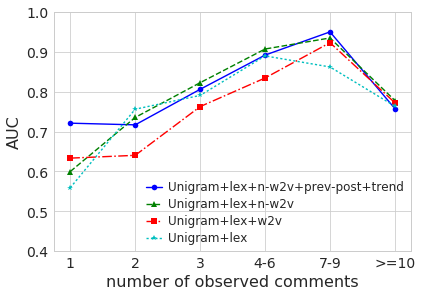

In [88]:
def task1_n_comments_fig(posts, features, lead_time=3):
    task1_sampled_posts = u.sample_posts_task1(posts,
                                               lead_time=lead_time*60*60)
    X, vec, feature_names, feature_classes = u.vectorize(task1_sampled_posts)
    feature_class2indices = get_feature_indices(feature_names, feature_classes)
    y = np.array([1 if p['num_hostile'] > 0 else 0 for p in task1_sampled_posts])        
    label_counts = Counter(y)
    all_results = []
    n_comments = np.array([p['n_comments_observed'] for p in task1_sampled_posts])
    for feature_list in features:
        col_indices = concat_indices(feature_class2indices, feature_list)
        XX = X[:, col_indices]
        res = {
                'features': feature_list,
                'lead_time': lead_time,
                'n_instances': len(y),
                'n_pos': label_counts[1],
                'n_neg': label_counts[0]}            
        res.update(u.cv(XX, y, n_splits=10, n_comments=n_comments))
        all_results.append(res)                                             
    df = pd.DataFrame(all_results)
    plot_task1_n_comments_fig(df)
    return df

def plot_task1_n_comments_fig(df):
    bins = {'1': [1],
            '2': [2],
            '3': [3],
            '4-6': [4,5,6],
            '7-9': [7,8,9],
            '>=10': range(10,500)
           }

    plt.figure()
    linecycler = get_lines()
    for features, by_n_comments in df[['features', 'by_n_comments']][::-1].values:
        # group results by number of comments
        nc2res = defaultdict(list)
        for x in by_n_comments:
            nc2res[x[2]].append((x[0], x[1]))
        rocs = []
        for label, ncs in sorted(bins.items()):
            res = []
            for nc in ncs:
                res.extend(nc2res[nc])
            rocs.append(roc_auc_score([v[0] for v in res],
                                      [v[1] for v in res], average=None))
        plt.plot(rocs, next(linecycler), label='+'.join(features))
    plt.xticks(range(len(bins)), sorted(bins))
    plt.legend(loc='lower right')
    plt.xlabel('number of observed comments')
    plt.ylabel('AUC')
    plt.ylim((.4, 1))
    plt.setp(plt.legend().get_texts(), fontsize='12') 
    plt.savefig('forecast_comments.pdf')
    plt.show()


n_comments_res = task1_n_comments_fig(task1_posts,
                                      features=[('Unigram', 'lex'),
                                                ('Unigram', 'lex', 'w2v'),
                                                ('Unigram', 'lex', 'n-w2v'),
                                                ('Unigram', 'lex', 'n-w2v', 'prev-post', 'trend'),
                                                ],
                                      lead_time=3)

In [8]:
def load_predicted_vectors(words, w2v=u.w2v_model_3gram, dim=100):
    vecs = []
    for wd in words:
        vecs.append(u.get_vector(wd, w2v, dim))
    return np.array(vecs)

def get_top_w2v_words(words, word_vecs, idx, n=20):
    return words[word_vecs[:,idx].argsort()[::-1][:n]]

def get_top_features_task1(task1_posts, lead_time=3, nfeats=40,
                             features=('Unigram', 'user', 'trend', 'lex',
                                      'n-w2v', 'final-com', 'prev-post')):
    task1_sampled_posts = u.sample_posts_task1(task1_posts, lead_time=3*60*60)
    X, vec, feature_names, feature_classes = u.vectorize(task1_sampled_posts)
    feature_class2indices = get_feature_indices(feature_names, feature_classes)
    y = np.array([1 if p['num_hostile'] > 0 else 0 for p in task1_sampled_posts])
    col_indices = concat_indices(feature_class2indices, features)
    XX = X[:,col_indices]
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(XX, y)
    fnames = np.concatenate(feature_names)
    fnames = fnames[col_indices]
    words = np.array(feature_names[feature_classes.index('Unigram')])
    word_vecs = load_predicted_vectors(words)
    results = []
    for i in np.argsort(clf.coef_[0])[::-1][:nfeats]:
        res = {'feature': fnames[i], 'coef': clf.coef_[0][i]}
        if 'neww2v' in fnames[i]:
            idx = int(re.findall('_([0-9]+)\-', fnames[i])[0])
            res['w2v'] = ' '.join(get_top_w2v_words(words, word_vecs, idx))
        results.append(res)
    results = pd.DataFrame(results)
    display(results)
    return results

In [9]:
get_top_features_task1(task1_posts)

total non-zero posts 299
sampled 299 negative posts
sampled 299 positive posts
9 feature classes, 13860 features


,coef,feature,w2v
0,0.484513,final_comment_profaneLexicon_1-th,NaN
1,0.460736,neww2v_maximum_76-th,cable comic hilarious skull angle movies marvel cgi badass superman cardio rp lens spider movie ...
2,0.442891,to,NaN
3,0.440365,pre_post_neww2v_maximum_32-th,floyd psn imy nicki kys fr cuss grave duke fb fag non creepy princess shes 1v1 glo si unfollow ton
4,0.424775,neww2v_maximum_34-th,hottt hottie bom lindo hott girlll gorg yhu asf knees goals imy que slayy roads booty hoes babe ...
5,0.414701,pre_post_you,NaN
6,0.406525,who,NaN
7,0.384932,final_comment_that,NaN
8,0.381230,neww2v_maximum_33-th,om bang kim ten kanye te miles don wyd po dr 23 30 bobby mee 12 dre 11 oop 45
9,0.380310,is,NaN


,coef,feature,w2v
0,0.484513,final_comment_profaneLexicon_1-th,NaN
1,0.460736,neww2v_maximum_76-th,cable comic hilarious skull angle movies marvel cgi badass superman cardio rp lens spider movie ...
2,0.442891,to,NaN
3,0.440365,pre_post_neww2v_maximum_32-th,floyd psn imy nicki kys fr cuss grave duke fb fag non creepy princess shes 1v1 glo si unfollow ton
4,0.424775,neww2v_maximum_34-th,hottt hottie bom lindo hott girlll gorg yhu asf knees goals imy que slayy roads booty hoes babe ...
5,0.414701,pre_post_you,NaN
6,0.406525,who,NaN
7,0.384932,final_comment_that,NaN
8,0.381230,neww2v_maximum_33-th,om bang kim ten kanye te miles don wyd po dr 23 30 bobby mee 12 dre 11 oop 45
9,0.380310,is,NaN


## Task 2

Given the first $N$ comments up to and including the first hostile comment, predict whether there will be less than $M$ or more than $Q$ hostile comments total.

In [89]:
task2_posts = u.load_posts(path + 'task2_data.json', path + 'task2_labels.json')
u.set_n_comments_observed_task2(task2_posts)
print('read %d posts' % len(task2_posts))

read 591 posts


In [90]:
# print first hostile comment.
#cts = Counter()
#for p in task2_posts:
#    #comment = ' '.join(p['comments'][i] for i in u.get_hostile_indices(p))
#    comment = ' '.join(c for c,l in zip(p['comments'][:10], p['labels'][:10]) if l == 'Innocuous')
#    #print(p['num_hostile'], comment)
#    cts.update(re.findall('\w+', comment.lower()))
#cts.most_common(200)

In [39]:
instigators = Counter()
for p in task2_posts:
    fi = u.get_hostile_indices(p)[0]
    instigators.update([p['users'][fi]])
print(len(instigators))
instigators.most_common(20)

554


[('weloverealitytv', 6),
 ('redzbaby', 5),
 ('naya_islandgyalnika', 4),
 ('diedpurple', 3),
 ('jimwalrod1', 3),
 ('adam.mchale', 3),
 ('kyyngg', 3),
 ('evanaltuzarra', 3),
 ('markchris88', 2),
 ('viewsfromalex_', 2),
 ('ohwellshipsail', 2),
 ('thebigkohen', 2),
 ('kingbobandz', 2),
 ('nolimitmallyyyy', 2),
 ('joshbrownn2', 2),
 ('monicadesantiagox', 2),
 ('jokes_all_day_', 2),
 ('nadacosmetologist', 2),
 ('lilhomiedt', 2),
 ('crying_liberals', 2)]

In [21]:
# inspect some posts...
posts = [p for p in task2_posts if p['num_hostile'] < 5 and 'Hostile/Offensive' in p['labels'][:5]]
for p in posts[:5]:
    d = []
    for c, l, us in zip(p['comments'], p['labels'], p['users']):
        d.append({'label': l, 'user': us, 'comment': c})  # print(l, u, c)
    display(pd.DataFrame(d, columns=['label', 'user', 'comment']).head(5))
        

,label,user,comment
0,Innocuous,omgfuckoff_,"If the symptoms persist, try an overdose. \n#moon #sky"
1,Hostile/Offensive,omgfuckoff_,@total.hypocrite Fuck off with that ching-chong shit.
2,Hostile/Offensive,total.hypocrite,@omgfuckoff_ uneducated and racist.
3,Innocuous,sex_in_the_elevator,I'm already addicted
4,Innocuous,omgfuckoff_,@sex_in_the_elevator 😏


,label,user,comment
0,Innocuous,byrant_pimento,hang out
1,Innocuous,fg.llaa165,👍👍
2,Innocuous,medy_msafii,Nice 1
3,Hostile/Offensive,nikkipotnick_,YOU AH VEWY BIG FAGGOT YES?! EAT THE SHITHOLE YES YOU ❤️ LOVE EAT A SHITHOLE!
4,Hostile/Offensive,nikkipotnick_,@byrant_pimento FUCK OFF


,label,user,comment
0,Innocuous,fadedlif.e,COOL #fadedlife . . .\n.\n.\n.\n.\n.\n.\n\n#designs #graphicdesigner #graphics #graphicdesign #a...
1,Innocuous,yagirltes,something you wish you were
2,Innocuous,interiorswede,👍
3,Hostile/Offensive,makaylalyynnn,fag
4,Innocuous,makaylalyynnn,kys


,label,user,comment
0,Innocuous,brix_q8,@hellswagger @me_ent
1,Innocuous,its.hj,@brix_q8 badass Brix😂👍💯
2,Innocuous,i459x,😂😂😂
3,Hostile/Offensive,07ali_king,#217_4_ever bitch!!!
4,Hostile/Offensive,realbrixq8,#arabmob_MEent_4_ever ya walad ant #FAKE !!!! Tkfa estaw3b @07ali_king


,label,user,comment
0,Innocuous,waistedbelts,🍻
1,Innocuous,aishiaki,Looks like a nice area to b 😍
2,Hostile/Offensive,adam.mchale,Kill yourself
3,Innocuous,scottrusso,Word
4,Innocuous,mrs.jenisegroff,Sweet😎😎😎😎


In [91]:
# Vectorize
X, vec, feature_names, feature_classes = u.vectorize(task2_posts)
X.shape

(591, 13341)

In [92]:
feature_class2indices = get_feature_indices(feature_names, feature_classes)
sorted([(fc, len(i)) for fc, i in feature_class2indices.items()], key=lambda x: x[1])

9 feature classes, 13341 features


[('user', 2),
 ('trend', 4),
 ('lex', 16),
 ('n-w2v', 200),
 ('w2v', 200),
 ('final-com', 884),
 ('Unigram', 2805),
 ('prev-post', 3695),
 ('prev-com', 5535)]

In [93]:
def task2_expts(posts, X, vec, feature_class2indices,
                max_for_neg_class=1, min_for_pos_class=10):
    all_results = []
    idx = u.filter_by_num_hostile(posts,
                                  max_for_neg_class=max_for_neg_class,
                                  min_for_pos_class=min_for_pos_class)
    Xi = X[idx]
    postsi = posts[idx]
    y = np.array([1 if p['num_hostile'] >= min_for_pos_class else 0
                  for p in postsi])
    label_counts = Counter(y)
    for feature_classes, col_indices in enum_feature_subsets(feature_class2indices):                        
        res = {
                'features': feature_classes,
                'max_for_neg_class': max_for_neg_class,
                'min_for_pos_class': min_for_pos_class,
                'n_instances': len(idx),
                'n_pos': label_counts[1],
                'n_neg': label_counts[0]}
        XX = Xi[:,col_indices]
        # run cross-validation
        res.update(u.cv(XX, y, n_splits=10))
        all_results.append(res)
    return pd.DataFrame(all_results)
    
task2_results = task2_expts(task2_posts, X, vec, feature_class2indices)
print_results_table(task2_results)

best features: ('trend', 'user', 'final-com')


AUC          0.808317
F1           0.747458
Precision    0.740662
Recall       0.672821
Name: Unigram, dtype: float64

,AUC,F1,Precision,Recall
features,,,,
Unigram,0.808317,0.747458,0.740662,0.672821
U + w2v,0.753289,0.696415,0.661527,0.672601
U + prev-com,0.785610,0.701409,0.693794,0.604963
U + user,0.816824,0.761427,0.752489,0.694725
U + n-w2v,0.821087,0.774898,0.781468,0.710513
U + trend,0.825459,0.778410,0.782184,0.721136
U + lex,0.827341,0.775649,0.784586,0.705018
U + prev-post,0.841604,0.781953,0.828516,0.687509
U + final-com,0.879292,0.792341,0.804511,0.721996


\begin{tabular}{lrrrr}
\toprule
{} &   AUC &    F1 &  Precision &  Recall \\
\textbf{features     } &       &       &            &         \\
\midrule
\textbf{Unigram      } & 0.808 & 0.747 &      0.741 &   0.673 \\
\textbf{U + w2v      } & 0.753 & 0.696 &      0.662 &   0.673 \\
\textbf{U + prev-com } & 0.786 & 0.701 &      0.694 &   0.605 \\
\textbf{U + user     } & 0.817 & 0.761 &      0.752 &   0.695 \\
\textbf{U + n-w2v    } & 0.821 & 0.775 &      0.781 &   0.711 \\
\textbf{U + trend    } & 0.825 & 0.778 &      0.782 &   0.721 \\
\textbf{U + lex      } & 0.827 & 0.776 &      0.785 &   0.705 \\
\textbf{U + prev-post} & 0.842 & 0.782 &      0.829 &   0.688 \\
\textbf{U + final-com} & 0.879 & 0.792 &      0.805 &   0.722 \\
\textbf{Best         } & 0.913 & 0.805 &      0.785 &   0.772 \\
\bottomrule
\end{tabular}



/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


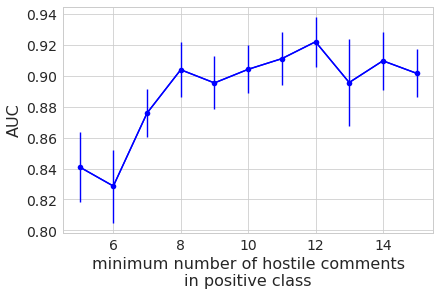

In [94]:
# Create table of AUC vs  min_for_pos_class
def task2_min_for_pos_class_fig(task2_results, posts, X, vec, feature_class2indices,
                                features,
                                max_for_neg_class=1,
                                min_for_pos_class_list=range(5,11)):
    col_indices = concat_indices(feature_class2indices, features)
    X = X[:,col_indices]
    all_results = []
    for min_for_pos_class in min_for_pos_class_list:
        idx = u.filter_by_num_hostile(posts,
                                      max_for_neg_class=max_for_neg_class,
                                      min_for_pos_class=min_for_pos_class)
        Xi = X[idx]
        postsi = posts[idx]
        y = np.array([1 if p['num_hostile'] >= min_for_pos_class else 0
                      for p in postsi])
        
        label_counts = Counter(y)
        res = {
                'features': feature_classes,
                'max_for_neg_class': max_for_neg_class,
                'min_for_pos_class': min_for_pos_class,
                'n_instances': len(idx),
                'n_pos': label_counts[1],
                'n_neg': label_counts[0]}
            
        # run cross-validation
        res.update(u.cv(Xi, y, n_splits=10))
        all_results.append(res)
    results_df = pd.DataFrame(all_results)
    plot_task2_fig(results_df)
    return results_df
            
def plot_task2_fig(task2_res_fig, nfolds=10):
    rr = task2_res_fig.sort_values('min_for_pos_class')[['min_for_pos_class', 'AUC', 'AUC_sd']].values
    xvals = rr[:,0]
    yvals = rr[:,1]
    stderrs = rr[:,2] / math.sqrt(nfolds) ## assuming 10-fold cv
    plt.figure()
    plt.plot(xvals, yvals, 'bo-')
    plt.errorbar(xvals, yvals, fmt='b', yerr=stderrs)
    plt.xlabel('minimum number of hostile comments\nin positive class')
    plt.ylabel('AUC')
    plt.tight_layout()
    plt.savefig('intensity_threshold.pdf')
    plt.show()

    
task2_pos_class_res = task2_min_for_pos_class_fig(task2_results, task2_posts, X, vec, feature_class2indices,
                            features=('Unigram', 'lex', 'n-w2v', 'prev-post', 'trend', 'user', 'final-com'),
                            max_for_neg_class=1,
                            min_for_pos_class_list=range(5,16))

In [95]:
def get_top_features_task2(task2_posts,
                             X, vec, feature_class2indices,
                             feature_names,
                             feature_classes,
                             features=('Unigram', 'user', 'trend', 'lex',
                                       'n-w2v', 'final-com', 'prev-post'),
                             min_for_pos_class=10,
                             max_for_neg_class=1,
                             nfeats=40):
    idx = u.filter_by_num_hostile(task2_posts,
                                  max_for_neg_class=max_for_neg_class,
                                  min_for_pos_class=min_for_pos_class)
    Xi = X[idx]
    postsi = task2_posts[idx]
    y = np.array([1 if p['num_hostile'] >= min_for_pos_class else 0
                  for p in postsi])
    col_indices = concat_indices(feature_class2indices, features)
    XX = Xi[:,col_indices]
    clf = LogisticRegression(class_weight='balanced')
    clf.fit(XX, y)
    fnames = np.concatenate(feature_names)
    fnames = fnames[col_indices]
    words = np.array(feature_names[feature_classes.index('Unigram')])
    word_vecs = load_predicted_vectors(words)
    results = []
    for i in np.argsort(clf.coef_[0])[::-1][:nfeats]:
        res = {'feature': fnames[i], 'coef': clf.coef_[0][i]}
        if 'neww2v' in fnames[i]:
            idx = int(re.findall('_([0-9]+)\-', fnames[i])[0])
            res['w2v'] = ' '.join(get_top_w2v_words(words, word_vecs, idx))
        results.append(res)
    results = pd.DataFrame(results)
    #display(results)
    return results

get_top_features_task2(task2_posts,
                         X, vec, feature_class2indices,
                         feature_names,
                         feature_classes,
                         features=('final-com',),
#                         features=('Unigram', 'user', 'trend', 'lex',
#                                   'n-w2v', 'final-com', 'prev-post'),
                         min_for_pos_class=10,
                         max_for_neg_class=1)

,coef,feature,w2v
0,0.935247,final_comment_neww2v_maximum_12-th,stole took emoji dying reminds grabbed cash skate slide stolen gotta calls lemme spit melt need ...
1,0.918695,final_comment_neww2v_maximum_6-th,wassup wya sup hawt foh imy hatin married whyyy wyd az mannn drinking lmmfao bish shutup bm bald...
2,0.812318,final_comment_neww2v_maximum_38-th,wavy dlow goddess ly slayy number color wears colour pure amo shade cutee shirt cash wear gorg b...
3,0.766997,final_comment_hatebase_10-th,NaN
4,0.706197,final_comment_stfu,NaN
5,0.686119,final_comment_the,NaN
6,0.673465,final_comment_shit,NaN
7,0.667902,final_comment_she,NaN
8,0.626330,final_comment_just,NaN
9,0.605946,final_comment_can,NaN


In [67]:
def top_hostile_terms(task1_posts, min_for_pos_class=10):
    """
    Find top log-odds terms for hostile comments.
    """
    comments_task1 = []
    comments_task2 = []
    labels_task1 = []
    labels_task2 = []
    for p in task1_posts:
        task2_label = 1 if p['num_hostile'] >= min_for_pos_class else 0
        for c,l in zip(p['comments'], p['labels']):
            labels_task1.append(0 if l=='Innocuous' else 1)
            text = u.cleanText(c)
            comments_task1.append(text)
            if labels_task1[-1] == 1:
                comments_task2.append(text)
                labels_task2.append(task2_label)
    vec = CountVectorizer(min_df=5, binary=True)
    X1 = vec.fit_transform(comments_task1)
    y1 = np.array(labels_task1)
    feats1 = np.array(vec.get_feature_names())
    X2 = vec.fit_transform(comments_task2)
    y2 = np.array(labels_task2)
    feats2 = np.array(vec.get_feature_names())
    
    def top_coef(X, y, feats, n=50):
        chi, _ = chi2(X, y)
        pos_counts = X[np.where(y==1)].sum(axis=0).A1
        neg_counts = X[np.where(y==0)].sum(axis=0).A1
        clf = LogisticRegression()
        clf.fit(X,y)
        coef = clf.coef_[0]
        for i in np.argsort(chi)[::-1][:n]:
            if coef[i] > 0:
                print(chi[i], pos_counts[i], neg_counts[i], feats[i])
    print('top terms predictive of hostile vs. non-hostile comment')
    top_coef(X1, y1, feats1, n=50)
    print('\n\n\ntop terms predictive of intense vs. non-intense hostility')
    top_coef(X2, y2, feats2, n=50)

top_hostile_terms(task1_posts, min_for_pos_class=10)

top terms predictive of hostile vs. non-hostile comment
4267.67188831 842 182 bitch
3795.22659419 873 311 ass
2125.6891322 515 209 fuck
1528.32708148 334 103 nigga
1213.53984878 476 436 shit
1005.76537036 176 20 faggot
998.904745302 176 21 dick
794.109157351 237 146 fucking
790.4519422 1266 3408 you
766.449749349 144 25 pussy
716.028737216 138 27 gay
703.072935694 572 1038 your
691.60495505 136 29 ugly
616.028020202 124 29 shut
582.057008492 115 25 hoe
542.841584388 114 31 fag
536.934151779 118 37 dumb
511.089947343 802 2138 and
504.258210585 177 140 yo
478.71311361 831 2322 to
444.94997032 494 1096 like
439.302220505 86 18 stfu
430.505183112 185 189 ur
387.550309931 87 29 fat
361.014323976 69 13 suck
350.851147829 95 49 kill
330.190835002 104 70 fake
329.871799387 329 684 don
313.416283036 459 1183 on
295.834885214 85 49 stupid
285.832273848 303 654 get
261.601109674 203 356 go
257.178086468 130 158 ain
254.839169467 104 100 yourself
249.614672547 140 188 off
247.448735138 292 671 her